In [1]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing
# !pip3 install lifelines

from twosample import binom_test_two_sided
from multitest import MultiTest
import seaborn

import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

from scipy.stats import poisson, binom, norm, hypergeom, uniform

import pandas as pd

from survival import evaluate_test_stats, multi_pvals
from twosample import binom_test
from test_gene_expression import two_groups_gene

In [2]:
lo_good_ds = ['hdfail', 'UnempDur', 'Aids2', 'Z243', 'support2', 'vlbw', 'prostate',
              'acath', 'actg', 'Rossi', 'Unemployment', 'grace']

In [3]:
from SurvSet.data import SurvLoader
loader = SurvLoader()

lo_ds_names = loader.df_ds.ds # List of available datasets and meta-info
acc = {}
for ds_name in lo_ds_names:
    df, ref = loader.load_dataset(ds_name=ds_name).values()
    if 'time2' in df.columns:
        df['diff'] = df['time2'] - df['time']
    else:
        df['diff'] = df['time']
    acc[ds_name] = df.groupby(['diff']).count()['event'].max()
    #if acc[ds_name] >= 10:
        #print(f"{ds_name}")
        #df.groupby(['diff']).count()['event'].hist(bins=np.arange(30))
        #plt.title(f"{ds_name}")
        #plt.show()
print(acc)

{'hdfail': 300, 'stagec': 5, 'veteran': 4, 'vdv': 2, 'AML_Bull': 3, 'LeukSurv': 26, 'zinc': 225, 'burn': 7, 'UnempDur': 517, 'nwtco': 7, 'rott2': 5, 'epileptic': 73, 'gse1992': 7, 'FRTCS': 7, 'cost': 3, 'rdata': 4, 'Aids2': 29, 'divorce': 16, 'micro.censure': 2, 'cgd': 4, 'pharmacoSmoking': 36, 'Z243': 15, 'NSBCD': 5, 'uis': 6, 'Dialysis': 665, 'nki70': 2, 'Melanoma': 2, 'cancer': 3, 'heart': 7, 'TRACE': 4, 'gse4335': 5, 'ova': 1, 'MCLcleaned': 2, 'smarto': 14, 'support2': 238, 'vlbw': 19, 'pbc': 2, 'DLBCL': 3, 'phpl04K8a': 7, 'dataDIVAT3': 25, 'dataDIVAT2': 36, 'wpbc': 7, 'GBSG2': 3, 'prostateSurvival': 289, 'dataDIVAT1': 307, 'e1684': 4, 'acath': 295, 'Framingham': 1122, 'colon': 4, 'follic': 24, 'mgus': 2, 'd.oropha.rec': 3, 'actg': 18, 'dataOvarian1': 22, 'hepatoCellular': 9, 'ovarian': 1, 'retinopathy': 4, 'Pbc3': 5, 'heartvalve': 35, 'Rossi': 160, 'whas500': 4, 'DBCD': 1, 'diabetes': 1, 'csl': 43, 'glioma': 4, 'aids': 371, 'chop': 4, 'Unemployment': 46, 'breast': 51, 'oldmort': 5

In [ ]:
from lifelines.statistics import logrank_test as logrank_lifeline

def log_rank_test_lifeline(Nt1, Nt2):
    lr = logrank_lifeline(Nt1, Nt2).summary
    return lr['test_statistic'][0], lr['p'][0]


? logrank_lifeline

## Illustrate Curves

In [344]:
def find_changes(Nt1, Nt2, Ot1, Ot2, stbl=True, gamma=.45):
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    mt = MultiTest(pvals[pvals<=1], stbl=stbl) 
    hc, hct = mt.hc(gamma=gamma)
    return pvals <= hct

def illustrate_survival_curve(Nt1, Nt2, Ot1, Ot2, Ct1, Ct2, stbl=True):
    
    stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=stbl, randomize=False)
    stats_rev = evaluate_test_stats(Nt2, Nt1, Ot2, Ot1, stbl=stbl, randomize=False)
        
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    pvals_rev = multi_pvals(Nt2, Nt1, Ot2, Ot1, randomize=False)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) 
    hc, hct = mt.hc(gamma=.2)
    #print("HC = ", hc)
    fpval = find_changes(Nt1, Nt2, Ot1, Ot2, stbl=True)
    
    dfg = pd.DataFrame()
    dfg['at_risk:0'] = Nt1
    dfg['at_risk:1'] = Nt2
    dfg['events1'] = Ot1
    dfg['events2'] = Ot2
    dfg['pvalue'] = pvals
    dfg['pvalue_rev'] = pvals_rev
    dfg['Survival Proportion X'] = (Nt1 - Ct1) / (np.max(Nt1) - Ct1)
    dfg['Survival Proportion Y'] = (Nt2 - Ct2) / (np.max(Nt2) - Ct2)
    
    df_disp = dfg[fpval]
    
    plt.step(dfg.index, dfg['Survival Proportion X'], 'b', where='pre')
    plt.step(dfg.index, dfg['Survival Proportion Y'], 'r', where='pre')
    s1 = 100 * Ct1 / np.max(Ct1) # size of censorship markers
    s2 = 100 * Ct2 / np.max(Ct2)
    plt.scatter(dfg.index[Ct1 > 0], dfg.loc[Ct1 > 0,'Survival Proportion X'],
                marker='+', c='k',
                s=s1[Ct1 > 0], alpha=.6)
    plt.scatter(dfg.index[Ct2 > 0], dfg.loc[Ct2 > 0,'Survival Proportion Y'],
                marker='+', c='k',
                s=s2[Ct2 > 0], alpha=.6)
    
    plt.legend([r'$\hat{S}_x$', r'$\hat{S}_y$'], fontsize=16, loc=1)
    
    plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2, width=.5)
    hc = stats['hc_greater']
    hc_rev = stats_rev['hc_greater']
    logrank = stats['log_rank_greater']

    st_HC = r"$\mathrm{HC}$"
    st_HC_rev = r"$\mathrm{Rev}(\mathrm{HC})$"
    st_LR = r"$\mathrm{LR}$"
    plt.title(rf"{st_HC}={np.round(hc,2)}, {st_HC_rev}={np.round(hc_rev,2)}, {st_LR}={np.round(logrank,2)}")
    #plt.title(f"{gene_name}, (HC={np.round(stats['hc_greater'],2)}, Log-rank={np.round(stats['log_rank_greater'],2)})")
    plt.ylabel('Survival Proportion', fontsize=16)
    plt.xlabel(r'$t$ (Time)', fontsize=16)
    
    return df_disp, dfg


def arrange_group(dfp):
    """
    Transform data from time to event to number of events per time duration

    Args:
        dfp is a dataframe with columns: "pid(index), time, event (0 or 1)"
        pid is the id of each patient in the study
        'time' is time to event
        1 indicates a failure event; 0 indicatet a censoring event
        
    Returns:
        dft  data frame with columns: 'time', 'at_risk', 'event', 'censored'
    """

    dfp.loc[:,'censored'] = 1 - dfp['event']
    total = len(dfp)
    
    dft = dfp.groupby('time').agg(sum)
    dd = (dft['censored'] + dft['event']).cumsum()
    dft['at_risk'] = total - np.array([0] + dd.tolist()[:-1])

    assert np.linalg.norm(dft['at_risk'].diff().values[1:] + dft['event'].values[:-1] + dft['censored'].values[:-1]) == 0
    return dft


def two_groups_gene(data, feature_name):
    """
    Arrange relevant data in two groups format for survival analysis based on
    the examined gene

    Args:
    :data:   is a dataframe with :gene_name: as one of its columns.
             additional columns are :time: and :event:

    Return:
        dataframe indexed by time and number of survived elements in
        each group

    """

    dfg = data[['pid', feature_name, 'time', 'event']]
    idc_split = dfg[feature_name] >= 1

    df1 = arrange_group(dfg[idc_split].set_index('pid'))
    df2 = arrange_group(dfg[~idc_split].set_index('pid'))

    dfm = df1[['at_risk', 'event', 'censored']].join(df2[['at_risk', 'event', 'censored']], lsuffix='1',
                                                             rsuffix='2', how='outer')
    dfm['event1'] = dfm['event1'].fillna(0)
    dfm['event2'] = dfm['event2'].fillna(0)
    dfm['censored:0'] = dfm['censored:0'].fillna(0)
    dfm['censored:1'] = dfm['censored:1'].fillna(0)
    dfm['at_risk:0'] = dfm['at_risk:0'].fillna(method='bfill').fillna(method='ffill')
    dfm['at_risk:1'] = dfm['at_risk:1'].fillna(method='bfill').fillna(method='ffill')
    return dfm


In [ ]:
def reduce_time_resolution(df, interval_duration):
    """
    Group together events in surivial data
    across uniform time intervals.

    Args:
    :df: original dataset
    :interval_duration:  duration of time interval over which we consolidate samples

    """

    df['time'] == df['time'] // interval_duration
    return df


In [345]:
feature_name = 'group'
dfg = df[['pid', feature_name, 'time', 'event']]
idc_split = dfg[feature_name] >= 1
df1 = arrange_group(dfg[idc_split])
df2 = arrange_group(dfg[~idc_split])

/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_68759/2693327723.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp.loc[:,'censored'] = 1 - dfp['event']
/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_68759/2693327723.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp.loc[:,'censored'] = 1 - dfp['event']


In [348]:
df

,pid,event,time,num_age,num_reprate,num_disrate,num_tenure,num_logwage,fac_ui,group
0,0,1,5,41,0.179,0.045,3,6.89568,no,0.0
1,1,1,13,30,0.520,0.130,6,5.28827,yes,1.0
2,2,1,21,36,0.204,0.051,1,6.76734,yes,0.0
3,3,1,3,26,0.448,0.112,3,5.97889,yes,1.0
4,4,1,9,22,0.320,0.080,0,6.31536,yes,0.0
...,...,...,...,...,...,...,...,...,...,...
3236,3236,1,11,41,0.520,0.260,3,5.69373,yes,1.0
3237,3237,0,4,27,0.499,0.249,0,5.92959,yes,1.0
3238,3238,0,5,30,0.520,0.260,6,5.80513,yes,1.0
3239,3239,1,1,29,0.520,0.260,3,5.24175,no,1.0


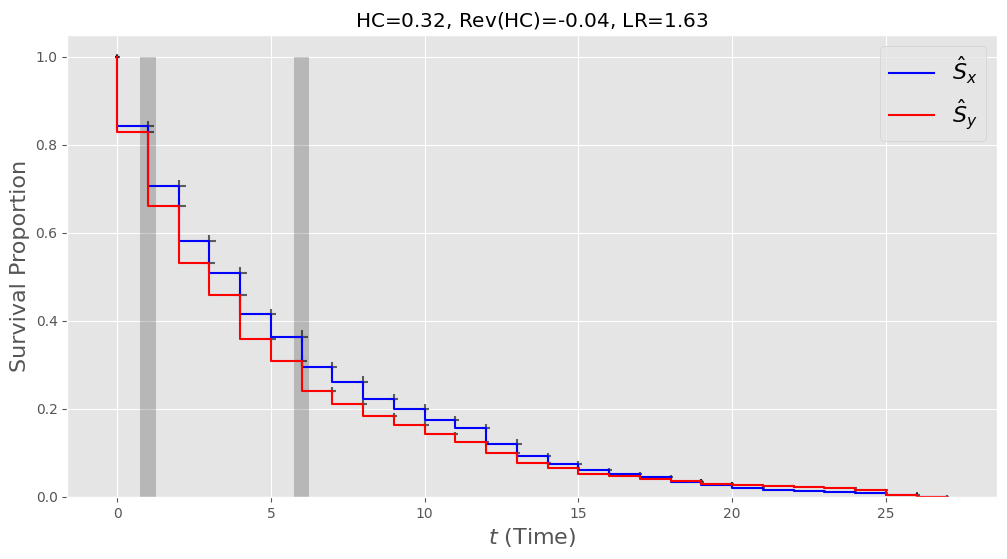

In [349]:
def partition_by(df, feature, value):
    df.loc[:, 'group'] = (df[feature] > value) + 0.
    return df

ds_name = 'UnempDur'
feature_name = 'num_logwage'

df, ref = loader.load_dataset(ds_name=ds_name).values()

value = df[feature_name].median()

dfp = partition_by(df, feature_name, value).filter(['pid', 'time', 'time1','time2', 'event', 'group', feature_name])
dfg = two_groups_gene(dfp, 'group')


Nt1 = dfg['at_risk:0']
Nt2 = dfg['at_risk:1']
Ot1 = dfg['event1']
Ot2 = dfg['event2']
Ct1 = dfg['censored:0']
Ct2 = dfg['censored:1']
r = illustrate_survival_curve(np.array(Nt1), np.array(Nt2),
                          np.array(Ot1), np.array(Ot2), np.array(Ct1), np.array(Ct2))

HERE!! understand why disagreement between methods on Nt1 and Nt2

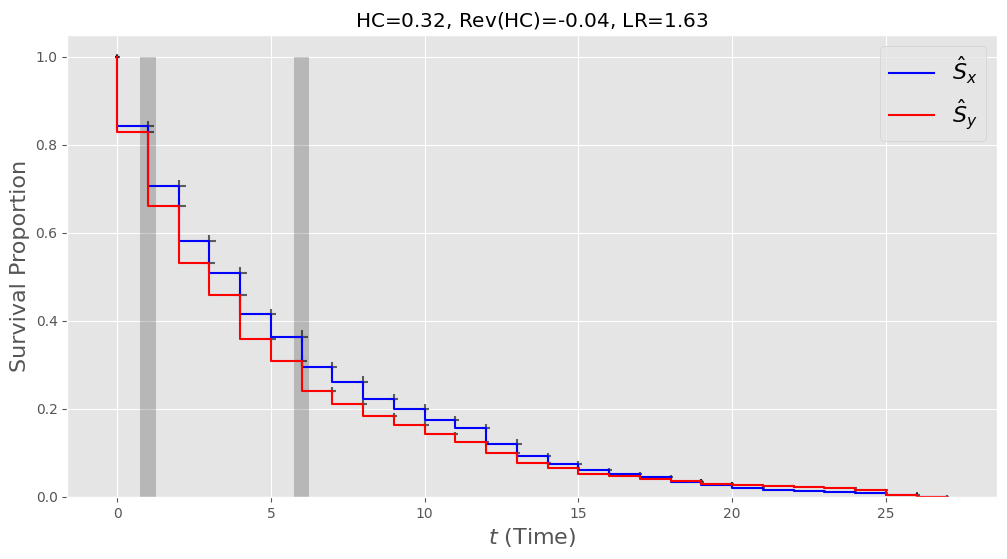

In [54]:

multi_pvals(np.array([965, 978]), np.array([967, 981]), np.array([7, 13]), np.array([16, 14]), randomize=False)

array([0.04608199, 0.5032255 ])

In [48]:
dfs = df_all.copy()
dfs.index.name='time'

for c in ['at_risk:0', 'at_risk:1', 'events1', 'events2']:
    dfs[c] = dfs[c].astype(int)
    
dfs['pvalue'] = np.round(dfs['pvalue'], 5)
    
dfr = dfs[:-1].filter(['at_risk:0', 'at_risk:1', 'events1', 'events2', 'pvalue'])\
#dfr.to_csv(remote_dir + 'csv/survival_curve_exm_new.csv')
dfr[:-1]

,at-risk1,at-risk2,events1,events2,pvalue
time,,,,,
0,1000,1000,22,19,0.73579
1,978,981,13,14,0.50323
2,965,967,16,7,0.98339
3,949,960,14,19,0.25211
4,935,941,13,10,0.80337
5,922,931,12,18,0.18596
6,910,913,10,10,0.59150
7,900,903,13,17,0.29392
8,887,886,9,13,0.25955


## With censorship

# Porportional Rates

In [41]:
from sample_survival_poisson import sample_survival_poisson_proportional
from survival import *


def evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, **kwargs):
    """
    Evaluate many tests for comparing the lists Nt1 and Nt2

    Args:
    :Nt1: first list of at_risk subjects
    :Nt2: second list of at_risk subjects
    :Ot1: number of events in group 1
    :Ot2: number of events in group 2


    Compute several statistics of the two-sample data:
    log-rank
    higher criticism
    Fisher combination test
    minimum P-value
    Berk-Jones
    Wilcoxon ranksum
    """

    randomize = kwargs.get('randomize', False)
    alternative = kwargs.get('alternative', 'both')  # 'both' != 'two-sided'
    stbl = kwargs.get('stbl', False)
    discard_ones = kwargs.get('discard_ones', True) # ignore P-values that are one

    test_results = {}

    #test_results['log_rank_lifeline'] = -np.log(lrln_pval + EPS)
    
    if alternative == 'both':
        r_greater = _evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, alternative='greater',
                            stbl=stbl, randomize=randomize)
        r_less = _evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, alternative='less',
                            stbl=stbl, randomize=randomize)            
        
        return dict(
            [(k + '_greater',r_greater[k])  for k in r_greater.keys()]  +
            [(k + '_less',r_less[k])  for k in r_less.keys()])
    else:
        r = _evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, alternative=alternative,
                            stbl=stbl, randomize=randomize)
        
        return dict([(k+'_' + alternative,r[k])  for k in r.keys()])

    return test_results

def _evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, alternative,
                         randomize=False,
                         stbl=False, discard_ones=True):
    """
    Evaluate many tests for comparing the lists Nt1 and Nt2

    Args:
    :Nt1: first list of at_risk subjects
    :Nt2: second list of at_risk subjects
    :Ot1: number of events in group 1
    :Ot2: number of events in group 2


    Compute several statistics of the two-sample data:
    log-rank
    higher criticism
    Fisher combination test
    minimum P-value
    Berk-Jones
    Wilcoxon ranksum
    """


    test_results = {}
    
    lr, lr_pval = log_rank_test(Nt1, Nt2, Ot1, Ot2, alternative=alternative)
    test_results['log_rank'] = lr  # large values are significant

    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, alternative=alternative,
                                randomize=randomize)
    if discard_ones:
        pvals = pvals[pvals < 1]
    mt = MultiTest(pvals, stbl=stbl)
    # if not using stbl=False, then sometimes
    # HC misses the significance of the strongest effect
    test_results['hc'] = mt.hc()[0]
    test_results['fisher'] = mt.fisher()
    test_results['min_p'] = mt.minp()
    test_results['berk_jones'] = mt.berk_jones(gamma=.45)
    test_results['wilcoxon'] = -np.log(scipy.stats.ranksums(
        Nt1, Nt2, alternative=alternative).pvalue + EPS)

    return test_results



def log_rank_test(Nt1, Nt2, Ot1, Ot2, alternative='two-sided'):
    """
    log-rank test 
    We assume that len(Nt1) == len(Nt2), and that each
    entry in either list represents an event in which
    a change occurs in the number of items in each groups 
    (the change in each group may also be zero)

    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2
    :alternative:   options are: 'greater', 'less', or 'two-sided'
                    with 'greater', test against the alternative that
                    more events occured in Nt2 compared to Nt1
    Returns:
    -------
    :z:       z score of the log-rank test
    :pvalue:  P-value
    """

    assert (len(Nt1) == len(Nt2))
    assert (len(Ot1) == len(Ot2))
    assert (len(Ot1) == len(Nt1))

    Nt = Nt2 + Nt1
    e0 = Nt2 * (Ot1 + Ot2) / Nt
    var0 = e0 * ((Nt - (Ot1 + Ot2)) / Nt) * (Nt1 / (Nt - 1))

    z = np.sum(Ot2 - e0) / np.sqrt(np.sum(var0))

    
    if alternative == 'greater':
        pval = norm.sf(z)
    elif alternative == 'less':
        pval = norm.cdf(z)
    else:
        pval = 2 * norm.cdf(-np.abs(z))

    print(f"(log_rank_test) Alternative = {alternative}, P-value = {pval}")
    return z, pval



In [42]:
def sample_survival_poisson_proportional(T, N1, N2, lam0, r):
    """
    Similar to `sample_survival_poisson' except
    that we model censorship using a poisson noise
    with rate :lamc: in both groups

    Args:
    -----
    :T:    number of events
    :N1:   total in group 1 at t=0
    :N2:   total in group 2 at t=0
    :lam0: base Poisson rate
    :r:    intensity of non-null events

    Note that since we sample from two Poisson distributions
    in each 'event', there is some possibility that we draw (O1,O2) = (0,0),
    hence there is no change in that event. This situation is different
    from standard notation.

    """

    Nt1 = np.zeros(T + 1)
    Nt2 = np.zeros(T + 1)

    lam1 = lam0
    lam2 = lam0 * (1 + r)  # `base` Poisson rates (does not have to be fixed)

    Nt1[0] = N1
    Nt2[0] = N2

    for t in np.arange(T):
        O1 = poisson.rvs(Nt1[t] * lam1[t] * (Nt1[t] > 0))
        O2 = poisson.rvs(Nt2[t] * lam2[t] * (Nt2[t] > 0))
        Nt1[t + 1] = np.maximum(Nt1[t] - O1, 0)
        Nt2[t + 1] = np.maximum(Nt2[t] - O2, 0)
        
    return Nt1, Nt2


In [44]:
T = 100
N1 = 1000
N2 = 1000

lam_bar = 0.001

lam0 = lam_bar * np.ones(T)

r = 0.1

Nt1, Nt2 = sample_survival_poisson_proportional(T, N1, N2, lam0, r)

Ot1 = -np.append(np.diff(Nt1), 0)
Ot2 = -np.append(np.diff(Nt2), 0)

df = pd.DataFrame({
    'at_risk:0': Nt1,
    'at_risk:1': Nt2,
    'events1': Ot1,
    'events2': Ot2
})

evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, alternative='both')

(log_rank_test) Alternative = greater, P-value = 0.7000094755135027
(log_rank_test) Alternative = less, P-value = 0.2999905244864973


{'log_rank_greater': -0.5244277654618411,
 'hc_greater': -2.0654965902539786,
 'fisher_greater': 1.1493259623542287,
 'min_p_greater': 2.079442385088743,
 'berk_jones_greater': 21.057768331369264,
 'wilcoxon_greater': 0.3612906717505249,
 'log_rank_less': -0.5244277654618411,
 'hc_less': -1.4264954269934067,
 'fisher_less': 1.400224110398608,
 'min_p_less': 2.7757096599983804,
 'berk_jones_less': 12.281375144295192,
 'wilcoxon_less': 1.193284909903878}

% Fisher ~ 1.5

In [125]:
def evaluate(itr, T, N1, N2, lam0, r):
    """
    order of arguments is important!
    evalaute an atomic experiment
    """
    Nt1, Nt2 = sample_survival_poisson_proportional(T, N1, N2, lam0, r)
    Ot1 = -np.diff(Nt1)
    Ot2 = -np.diff(Nt2)
    res = evaluate_test_stats(Nt1[:-1], Nt2[:-1], Ot1, Ot2,
                              randomized=True, alternative='both')
    return res


def test_power(T0, T1, alpha):
    talpha = np.quantile(T0, 1 - alpha) 
    return np.mean(T1 > talpha)

In [168]:
nMonte = 10000

lam0 = np.ones(T) / T
r = 0

res0 = pd.DataFrame()
for itr in tqdm(range(nMonte)):
    res0 = res0.append(evaluate(1, T, N1, N2, lam0, r), ignore_index=True)

100%|██████████| 10000/10000 [01:45<00:00, 94.88it/s]


In [171]:
#power LR:
alpha = 0.05


nMonte = 10000

lam0 = np.ones(T) / T

r = 0.1

for r in [0.05, 0.1, 0.15, 0.2]:
    res = pd.DataFrame()
    for itr in tqdm(range(nMonte)):
        res = res.append(evaluate(1, T, N1, N2, lam0, r), ignore_index=True)

    print(f"r = {r}")
    print("LR: ", test_power(res0.log_rank_greater, res.log_rank_greater, alpha))
    print("Fisher: ", test_power(res0.fisher_greater, res.fisher_greater, alpha))

  0%|          | 10/10000 [00:00<01:49, 91.49it/s]

r = 0.05
LR:  0.1481
Fisher:  0.1868


  0%|          | 10/10000 [00:00<01:46, 93.58it/s]

r = 0.1
LR:  0.4125
Fisher:  0.4496


  0%|          | 10/10000 [00:00<01:46, 94.00it/s]

r = 0.15
LR:  0.7159
Fisher:  0.7223


100%|██████████| 10000/10000 [01:48<00:00, 92.49it/s]

r = 0.2
LR:  0.9204
Fisher:  0.911


(array([3.083e+03, 2.592e+03, 1.949e+03, 1.243e+03, 6.690e+02, 3.000e+02,
        1.180e+02, 3.600e+01, 7.000e+00, 3.000e+00]),
 array([5.02388159e-05, 3.96518188e-01, 7.92986137e-01, 1.18945409e+00,
        1.58592203e+00, 1.98238998e+00, 2.37885793e+00, 2.77532588e+00,
        3.17179383e+00, 3.56826178e+00, 3.96472973e+00]),
 <a list of 10 Patch objects>)

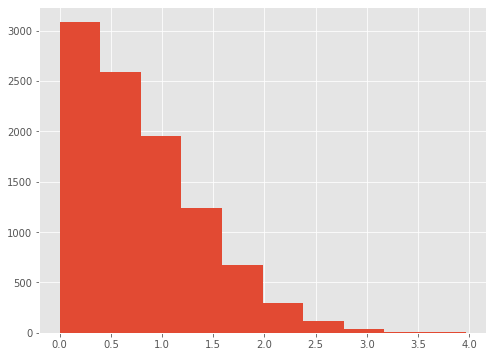

In [178]:
plt.hist(res0.log_rank_greater)

In [183]:
from survival import log_rank_test
log_rank_test(Nt1, Nt2, Ot1, Ot2, alternative='greater')

(0.08781591983209125, 0.46501149222618876)

In [187]:
evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, randomized=False, alternative='less')

{'log_rank_less': 0.08781591983209125,
 'hc_less': -1.5985833156999265,
 'fisher_less': 1.2705746367507702,
 'min_p_less': 2.0794423404355875,
 'berk_jones_less': 12.868822814349734,
 'wilcoxon_less': 0.2709153533053485}